In [1]:
from argparse import ArgumentParser
from snewpy import to_snowglobes
from snewpy import run_snowglobes
from snewpy import from_snowglobes
import tarfile
import numpy as np
import os
from astropy.io import ascii
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

rng = np.random.default_rng()


mpl.rcParams['figure.figsize']=(6.0,4.0)    #(6.0,4.0)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.handlelength']=2
mpl.rcParams['legend.fontsize']=16
mpl.rcParams['legend.frameon']=False
mpl.rcParams['axes.labelsize']=18
mpl.rcParams['xtick.labelsize']=16
mpl.rcParams['ytick.labelsize']=16
mpl.rcParams['legend.labelspacing'] = 0.1
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.direction'] = 'inout'

home_directory = os.getcwd()
SNOwGLoBES_path = "/Users/eoco/research/github/snowglobes/" #where snowglobes is located


In [2]:
#set distance in kpc
distance=10

#set SNOwGLoBES detector to use
detectors = ["wc100kt30prct","scint20kt","ar40kt","icecube"]

#set SNEWPY model type and filename
modeltype = 'OConnor_2015'
modeldir = '/Users/eoco/research/github/NeutrinoEchos/scripts/'
model = 's40_atBH_10km'
filename = model+'.dat'

#to_snowglobes.generate_fluence integrates the model over the
#specified time window(s) and generates fluence files for snowglobes

#Option 1 - don't specify tstart and tend, then the whole model is integrated
#tstart = None
#tend = None

#Option 2 - specify single tstart and tend, this makes 1 fluence file integrated over the windown
#tstart = 0.5372223 *u.s
#tend= 0.5598223 *u.s

#Option 3 = specify sequence of time intervals, one fluence
#file is made for each elements with dt=tstart[i]-tend[i]
window_tstart = 0.5300223
window_bins = 299
window_tend = 0.5599222
tstart = np.linspace(window_tstart,window_tend,window_bins,endpoint=False)*u.s
tend = tstart + (window_tend-window_tstart)/window_bins*u.s
tmid = (tstart+tend)*0.5

#set desired oscillation prescription
transformation = 'AdiabaticMSW_NMO'
#transformation = 'AdiabaticMSW_IMO'

#to_snowglobes creates a tarred file of snowglobes fluences
#this is stored in the model types directory in the snewpy/models
#the full path is returned from to_snowglobes
outfile = modeltype+"_"+model+"_"+transformation

Below is the code that calls SNEWPY and SNOwGLoBES.  We have provided the .npy files so this step isn't needed unless you want to do it
==

In [3]:
#call to_snowglobes
tables = {}

print("Preparing fluences...")
tarredfile = to_snowglobes.generate_fluence(modeldir, filename, modeltype, transformation, distance, outfile,tstart,tend)
print("Done fluences...")

for detector in detectors:
    print("Running snowglobes with",detector,"...")
    #now run snowglobes, this will loop over all the fluence files in `tarredfile`
    run_snowglobes.go(SNOwGLoBES_path, modeldir, tarredfile, detector_input=detector,verbose=False)
    print("Done snowglobes...")
    
    #now collate results of output of snowglobes
    print("Collating...")
    tables[detector] = from_snowglobes.collate(SNOwGLoBES_path, modeldir, tarredfile, detector_input=detector,skip_plots=True,return_tables=True,verbose=False)

os.chdir(home_directory)
np.save(modeldir+'NeutrinoEcho_'+outfile+'.npy',tables)

Preparing fluences...
[INFO] The `generate_fluence` function has been moved to the `snewpy.snowglobes` module.
Done fluences...
Running snowglobes with wc100kt30prct ...
[INFO] The `go` function has been moved to the `snewpy.snowglobes` module.


Detectors: 100%|██████████| 1/1 [00:49<00:00, 49.27s/it]


Done snowglobes...
Collating...
[INFO] The `collate` function has been moved to the `snewpy.snowglobes` module.
Running snowglobes with scint20kt ...
[INFO] The `go` function has been moved to the `snewpy.snowglobes` module.


Detectors:   0%|          | 0/1 [00:00<?, ?it/s]WARNING:snewpy.snowglobes_interface:Missing efficiencies for detector=scint20kt!


Detectors: 100%|██████████| 1/1 [01:07<00:00, 67.20s/it]


Done snowglobes...
Collating...
[INFO] The `collate` function has been moved to the `snewpy.snowglobes` module.
Running snowglobes with ar40kt ...
[INFO] The `go` function has been moved to the `snewpy.snowglobes` module.


Detectors: 100%|██████████| 1/1 [00:52<00:00, 52.29s/it]


Done snowglobes...
Collating...
[INFO] The `collate` function has been moved to the `snewpy.snowglobes` module.
Running snowglobes with icecube ...
[INFO] The `go` function has been moved to the `snewpy.snowglobes` module.


Detectors: 100%|██████████| 1/1 [00:48<00:00, 48.56s/it]


Done snowglobes...
Collating...
[INFO] The `collate` function has been moved to the `snewpy.snowglobes` module.


Plots the rates for the normal mass ordering with adiabatic resonances
==

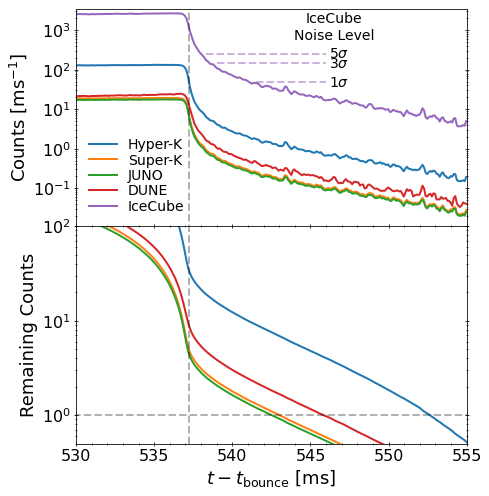

Total Events Hyper-K-like: 36.06322861075721
Total Events Super-K-like: 5.245560525201048
Total Events JUNO-like: 4.738433942698793
Total Events DUNE-like: 9.469965064418467
Total Events IceCube-like: 959.2777331897663


In [3]:
%matplotlib inline
tables = np.load("./NeutrinoEcho_OConnor_2015_s40_atBH_10km_AdiabaticMSW_NMO.npy",allow_pickle=True).item()
outfile = 'OConnor_2015_s40_atBH_10km_AdiabaticMSW_NMO'
nevents = {}
for detector in detectors:
    nevents[detector] = np.zeros(len(tmid))
    for i in range(len(tmid)):
        key = "Collated_"+outfile+"_"+str(i)+"_"+detector+"_events_smeared_weighted.dat"
        for j in range(1,len(tables[detector][key]['header'].split())):
            nevents[detector][i] += sum(tables[detector][key]['data'][j])

#nevents is per bin, convert to per ms
factor = window_bins/(window_tend-window_tstart)/1000.

hyperKfactor = 2.2
superKfactor = 0.32
tbh = 537

total_hk = sum(hyperKfactor*nevents["wc100kt30prct"])
dwisum_hk = total_hk-np.cumsum(hyperKfactor*nevents["wc100kt30prct"])
total_sk = sum(superKfactor*nevents["wc100kt30prct"])
dwisum_sk = total_sk-np.cumsum(superKfactor*nevents["wc100kt30prct"])
total_juno = sum(nevents["scint20kt"])
dwisum_juno = total_juno-np.cumsum(nevents["scint20kt"])
total_dune = sum(nevents["ar40kt"])
dwisum_dune = total_dune-np.cumsum(nevents["ar40kt"])
total_icecube = sum(nevents["icecube"])
dwisum_icecube = total_icecube-np.cumsum(nevents["icecube"])

fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(2, 1,hspace=0.0) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(tmid*1000,hyperKfactor*nevents["wc100kt30prct"]*factor,label="Hyper-K")
ax1.plot(tmid*1000,superKfactor*nevents["wc100kt30prct"]*factor,label="Super-K")
ax1.plot(tmid*1000,nevents["scint20kt"]*factor,label="JUNO")
ax1.plot(tmid*1000,nevents["ar40kt"]*factor,label="DUNE")
ax1.plot(tmid*1000,nevents["icecube"]*factor,label="IceCube")

ax1.plot([tbh+4.5,tbh+9],[50,50],"C4--",alpha=0.5)
ax1.plot([tbh+2,tbh+9],[150,150],"C4--",alpha=0.5)
ax1.plot([tbh+1.3,tbh+9],[250,250],"C4--",alpha=0.5)

ax1.annotate(r'$1 \sigma$', xy=(tbh+7.5, 50*1.5),
            xytext=(tbh+10.5, 50*1.4), textcoords='data',fontsize=14,
            horizontalalignment='right', verticalalignment='top')
ax1.annotate(r'$3 \sigma$', xy=(tbh+7.5, 50*1.5),
            xytext=(tbh+10.5, 150*1.4), textcoords='data',fontsize=14,
            horizontalalignment='right', verticalalignment='top')
ax1.annotate(r'$5 \sigma$', xy=(tbh+7.5, 50*1.5),
            xytext=(tbh+10.5, 250*1.5), textcoords='data',fontsize=14,
            horizontalalignment='right', verticalalignment='top')
ax1.annotate("IceCube\nNoise Level", xy=(tbh+7.5, 60*2.4),
            xytext=(tbh+9.5, 1500*1.9), textcoords='data',fontsize=14,
            horizontalalignment='center', verticalalignment='top')

ax1.get_xaxis().set_ticks([])
ax1.set_ylabel("Counts [ms$^{-1}$]")
ax1.set_yscale('log')
ax1.set_xlim(530,555)
ax1.set_ylim(0.011,3500)
ax1.legend(handlelength=2,fontsize=14,loc="lower left")


ax2.plot(tmid*1000,dwisum_hk,label="Hyper-K")
ax2.plot(tmid*1000,dwisum_sk,label="Super-K")
ax2.plot(tmid*1000,dwisum_juno,label="JUNO")
ax2.plot(tmid*1000,dwisum_dune,label="DUNE")
#ax2.plot(tmid*1000,dwisum_icecube,label="IceCube")
ax2.set_xlabel("$t-t_\mathrm{bounce}$ [ms]")
ax2.set_ylabel("Remaining Counts")
ax2.set_yscale('log')
ax2.plot([tbh-100,tbh+100],[1,1],'k--',alpha=0.3)

ax1.plot([537.2,537.2],[1e-9,1e9],'k--',alpha=0.3)
ax2.plot([537.2,537.2],[1e-9,1e9],'k--',alpha=0.3)


ax2.set_ylim(0.5,100)
ax2.set_xlim(530,555)
#ax2.legend()


plt.savefig("./count_rate_snowglobes_NMO_10km.pdf",bbox_inches='tight')
plt.show()

print("Total Events Hyper-K-like:",hyperKfactor*sum(nevents["wc100kt30prct"][tmid>(tbh/1000+0.0002)*u.s]))
print("Total Events Super-K-like:",superKfactor*sum(nevents["wc100kt30prct"][tmid>(tbh/1000+0.0002)*u.s]))
print("Total Events JUNO-like:",sum(nevents["scint20kt"][tmid>(tbh/1000+0.0002)*u.s]))
print("Total Events DUNE-like:",sum(nevents["ar40kt"][tmid>(tbh/1000+0.0002)*u.s]))
print("Total Events IceCube-like:",sum(nevents["icecube"][tmid>(tbh/1000+0.0002)*u.s]))

Sampling of HyperK-like realization
=========

In [4]:
nevents = {}
nevents_vs_e = {}
detector="wc100kt30prct"
nevents[detector] = np.zeros(len(tmid))
nevents_vs_e[detector] = np.zeros(len(tmid)*200).reshape(len(tmid),200)
energies = np.linspace(0.5,100,200,endpoint=False)
for i in range(len(tmid)):
    key = "Collated_"+outfile+"_"+str(i)+"_"+detector+"_events_smeared_weighted.dat"
    for j in range(1,len(tables[detector][key]['header'].split())):
        nevents[detector][i] += sum(tables[detector][key]['data'][j])
        nevents_vs_e[detector][i] += tables[detector][key]['data'][j]
            
i=0
eventt = []
eventy = []
for time in tmid:
    lt = time*1000
    lcumsum = np.cumsum(nevents_vs_e[detector][i])
    lcumsum = lcumsum/lcumsum[-1]
    
    lrate = hyperKfactor*nevents["wc100kt30prct"]*factor/10.
    levents = rng.poisson(lrate[i], 1)[0]
    dt = tend[i]-tstart[i]
    for j in range(levents):
        eventt.append(1000.*(rng.uniform(0,1)*dt/u.s+tstart[i]/u.s))
        rand = rng.uniform(0,1)
        le = np.interp(rand,lcumsum,energies)
        eventy.append(le)
    i += 1

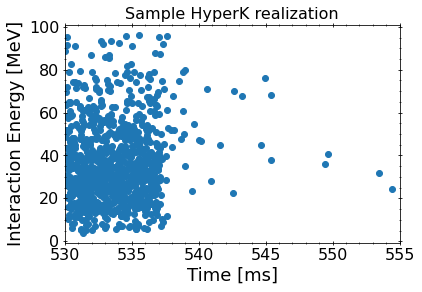

In [5]:
plt.scatter(eventt,eventy)
plt.ylabel("Interaction Energy [MeV]")
plt.xlabel("Time [ms]")
plt.title("Sample HyperK realization",fontsize=16)
plt.xlim(530,555)
plt.show()

What is the interaction causing the events
==

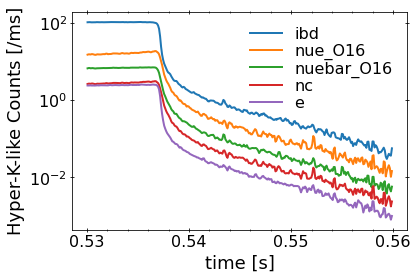

In [6]:
plt.clf()
nevents = {}
nevents_vs_e = {}
detector="wc100kt30prct"
nevents[detector] = np.zeros(len(tmid))
nevents_vs_e[detector] = np.zeros(len(tmid)*5).reshape(5,len(tmid))
energies = np.linspace(0.5,100,199,endpoint=False)
for i in range(len(tmid)):
    key = "Collated_"+outfile+"_"+str(i)+"_"+detector+"_events_smeared_weighted.dat"
    for j in range(1,len(tables[detector][key]['header'].split())):
        nevents[detector][i] += sum(tables[detector][key]['data'][j])
        nevents_vs_e[detector][j-1][i] = sum(tables[detector][key]['data'][j])
j=0
for j in range(5):
    plt.plot(tmid,2.2*factor*nevents_vs_e[detector][j],label=tables[detector][key]['header'].split()[j+1])
plt.legend()
plt.yscale('log')
plt.ylabel("Hyper-K-like Counts [/ms]")
plt.xlabel("time [s]")
plt.show()

Results for the inverted mass ordering, if .npy file doesn't exist, you need to run it above with transformation=AdiabaticMSW_IMO
==

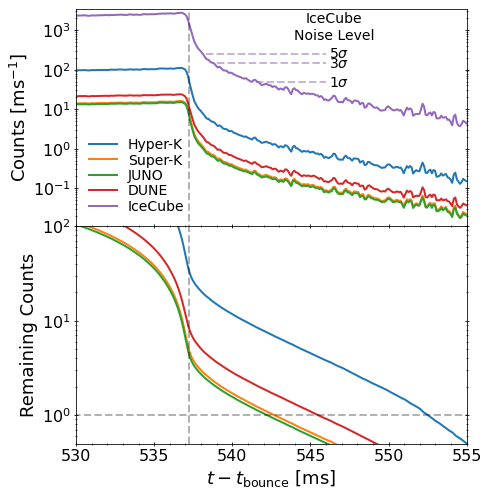

Total Events Hyper-K-like: 36.2161086017656
Total Events Super-K-like: 5.2677976148022685
Total Events JUNO-like: 4.749172462806555
Total Events DUNE-like: 8.851002955531685
Total Events IceCube-like: 1098.1472262375542


In [7]:
tables = np.load("./NeutrinoEcho_OConnor_2015_s40_atBH_10km_AdiabaticMSW_IMO.npy",allow_pickle=True).item()
outfile = 'OConnor_2015_s40_atBH_10km_AdiabaticMSW_IMO'
nevents = {}
for detector in detectors:
    nevents[detector] = np.zeros(len(tmid))
    for i in range(len(tmid)):
        key = "Collated_"+outfile+"_"+str(i)+"_"+detector+"_events_smeared_weighted.dat"
        for j in range(1,len(tables[detector][key]['header'].split())):
            nevents[detector][i] += sum(tables[detector][key]['data'][j])

#nevents is per bin, convert to per ms
factor = window_bins/(window_tend-window_tstart)/1000.

hyperKfactor = 2.2
superKfactor = 0.32
tbh = 537

total_hk = sum(hyperKfactor*nevents["wc100kt30prct"])
dwisum_hk = total_hk-np.cumsum(hyperKfactor*nevents["wc100kt30prct"])
total_sk = sum(superKfactor*nevents["wc100kt30prct"])
dwisum_sk = total_sk-np.cumsum(superKfactor*nevents["wc100kt30prct"])
total_juno = sum(nevents["scint20kt"])
dwisum_juno = total_juno-np.cumsum(nevents["scint20kt"])
total_dune = sum(nevents["ar40kt"])
dwisum_dune = total_dune-np.cumsum(nevents["ar40kt"])
total_icecube = sum(nevents["icecube"])
dwisum_icecube = total_icecube-np.cumsum(nevents["icecube"])

fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(2, 1,hspace=0.0) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(tmid*1000,hyperKfactor*nevents["wc100kt30prct"]*factor,label="Hyper-K")
ax1.plot(tmid*1000,superKfactor*nevents["wc100kt30prct"]*factor,label="Super-K")
ax1.plot(tmid*1000,nevents["scint20kt"]*factor,label="JUNO")
ax1.plot(tmid*1000,nevents["ar40kt"]*factor,label="DUNE")
ax1.plot(tmid*1000,nevents["icecube"]*factor,label="IceCube")

ax1.plot([tbh+4.5,tbh+9],[50,50],"C4--",alpha=0.5)
ax1.plot([tbh+2,tbh+9],[150,150],"C4--",alpha=0.5)
ax1.plot([tbh+1.3,tbh+9],[250,250],"C4--",alpha=0.5)

ax1.annotate(r'$1 \sigma$', xy=(tbh+7.5, 50*1.5),
            xytext=(tbh+10.5, 50*1.4), textcoords='data',fontsize=14,
            horizontalalignment='right', verticalalignment='top')
ax1.annotate(r'$3 \sigma$', xy=(tbh+7.5, 50*1.5),
            xytext=(tbh+10.5, 150*1.4), textcoords='data',fontsize=14,
            horizontalalignment='right', verticalalignment='top')
ax1.annotate(r'$5 \sigma$', xy=(tbh+7.5, 50*1.5),
            xytext=(tbh+10.5, 250*1.5), textcoords='data',fontsize=14,
            horizontalalignment='right', verticalalignment='top')
ax1.annotate("IceCube\nNoise Level", xy=(tbh+7.5, 60*2.4),
            xytext=(tbh+9.5, 1500*1.9), textcoords='data',fontsize=14,
            horizontalalignment='center', verticalalignment='top')

ax1.get_xaxis().set_ticks([])
ax1.set_ylabel("Counts [ms$^{-1}$]")
ax1.set_yscale('log')
ax1.set_xlim(530,555)
ax1.set_ylim(0.011,3500)
ax1.legend(handlelength=2,fontsize=14,loc="lower left")


ax2.plot(tmid*1000,dwisum_hk,label="Hyper-K")
ax2.plot(tmid*1000,dwisum_sk,label="Super-K")
ax2.plot(tmid*1000,dwisum_juno,label="JUNO")
ax2.plot(tmid*1000,dwisum_dune,label="DUNE")
#ax2.plot(tmid*1000,dwisum_icecube,label="IceCube")
ax2.set_xlabel("$t-t_\mathrm{bounce}$ [ms]")
ax2.set_ylabel("Remaining Counts")
ax2.set_yscale('log')
ax2.plot([tbh-100,tbh+100],[1,1],'k--',alpha=0.3)

ax1.plot([537.2,537.2],[1e-9,1e9],'k--',alpha=0.3)
ax2.plot([537.2,537.2],[1e-9,1e9],'k--',alpha=0.3)


ax2.set_ylim(0.5,100)
ax2.set_xlim(530,555)


plt.savefig("./count_rate_snowglobes_IMO_10km.pdf",bbox_inches='tight')
plt.show()
print("Total Events Hyper-K-like:",hyperKfactor*sum(nevents["wc100kt30prct"][tmid>(tbh/1000+0.0002)*u.s]))
print("Total Events Super-K-like:",superKfactor*sum(nevents["wc100kt30prct"][tmid>(tbh/1000+0.0002)*u.s]))
print("Total Events JUNO-like:",sum(nevents["scint20kt"][tmid>(tbh/1000+0.0002)*u.s]))
print("Total Events DUNE-like:",sum(nevents["ar40kt"][tmid>(tbh/1000+0.0002)*u.s]))
print("Total Events IceCube-like:",sum(nevents["icecube"][tmid>(tbh/1000+0.0002)*u.s]))